In [160]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Download and Prepare the Dataset

### donload the original images

In [ ]:
!wget -P /content/drive/MyDrive/dental-segmentation/raw-dataset https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/hxt48yk462-1.zip

--2023-05-31 12:04:12--  https://prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com/hxt48yk462-1.zip
Resolving prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com)... 52.218.98.56, 52.218.104.43, 3.5.69.139, ...
Connecting to prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com (prod-dcd-datasets-cache-zipfiles.s3.eu-west-1.amazonaws.com)|52.218.98.56|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 325134124 (310M) [application/octet-stream]
Saving to: ‘/content/drive/MyDrive/dental-segmentation/raw-dataset/hxt48yk462-1.zip’

hxt48yk462-1.zip    100%[===================>] 310.07M  17.6MB/s    in 17s     

2023-05-31 12:04:30 (17.8 MB/s) - ‘/content/drive/MyDrive/dental-segmentation/raw-dataset/hxt48yk462-1.zip’ saved [325134124/325134124]



In [ ]:
import zipfile
import os
import shutil

original_images_dataset_zip = '/content/drive/MyDrive/dental-segmentation/raw-dataset/hxt48yk462-1.zip'
destination_dir = '/content/drive/MyDrive/dental-segmentation/raw-dataset'
images_dir = 'images'

# Extract the raw dataset zip file in the raw-dataset folder
with zipfile.ZipFile(original_images_dataset_zip, 'r') as zip_ref:
    zip_ref.extractall(destination_dir)

# Path to the extracted DentalPanoramicXrays.zip file
dental_zip_path = os.path.join(destination_dir, 'DentalPanoramicXrays.zip')
dental_extract_dir = os.path.join(destination_dir, 'DentalPanoramicXrays')

# Extract the DentalPanoramicXrays.zip file inside the DentalPanoramicXrays folder
with zipfile.ZipFile(dental_zip_path, 'r') as zip_ref:
    zip_ref.extractall(dental_extract_dir)

# Define the paths to the extracted dataset folders
source_images_dir = os.path.join(dental_extract_dir, 'Images')

# Create the destination directories
destination_images_dir = os.path.join(destination_dir, images_dir)
os.makedirs(destination_images_dir, exist_ok=True)

# Move the image files
for filename in os.listdir(source_images_dir):
    source_path = os.path.join(source_images_dir, filename)
    destination_path = os.path.join(destination_images_dir, filename)
    shutil.move(source_path, destination_path)


# Remove the extracted dataset folder and the extracted DentalPanoramicXrays.zip file and other redundant files 
shutil.rmtree(dental_extract_dir)
os.remove(dental_zip_path)

print("Original Images extraction and organization completed successfully!")

# Count the number of images
images_count = len(os.listdir(os.path.join(destination_dir, 'images')))

# Print the number of images
print("All Images:", images_count)

Original Images extraction and organization completed successfully!
All Images: 116


### donload the masks

In [ ]:
!wget https://github.com/ImagingYeditepe/Segmentation-of-Teeth-in-Panoramic-X-ray-Image/raw/main/Original_Masks/Orig_Masks.zip -P /content/drive/MyDrive/dental-segmentation/raw-dataset/

--2023-05-31 12:27:34--  https://github.com/ImagingYeditepe/Segmentation-of-Teeth-in-Panoramic-X-ray-Image/raw/main/Original_Masks/Orig_Masks.zip
Resolving github.com (github.com)... 140.82.114.4
Connecting to github.com (github.com)|140.82.114.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/ImagingYeditepe/Segmentation-of-Teeth-in-Panoramic-X-ray-Image/main/Original_Masks/Orig_Masks.zip [following]
--2023-05-31 12:27:34--  https://raw.githubusercontent.com/ImagingYeditepe/Segmentation-of-Teeth-in-Panoramic-X-ray-Image/main/Original_Masks/Orig_Masks.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3235413 (3.1M) [application/zip]
Saving to: ‘/content/drive/MyDrive/dental-segmentation/raw-d

In [ ]:
masks_dataset_zip = '/content/drive/MyDrive/dental-segmentation/raw-dataset/Orig_Masks.zip'

destination_dir = '/content/drive/MyDrive/dental-segmentation/raw-dataset/masks'

# Create the extraction directory if it doesn't exist
os.makedirs(destination_dir, exist_ok=True)

# Extract the contents of the zip file
with zipfile.ZipFile(masks_dataset_zip, 'r') as zip_ref:
    zip_ref.extractall(destination_dir)

print("Masks extraction and organization completed successfully!")
# Count the number of masks
images_count = len(os.listdir(destination_dir))

# Print the number of masks
print("All Masks:", images_count)

Masks extraction and organization completed successfully!
All Masks: 116


In [3]:
import os
from PIL import Image

def calculate_target_size(directory):
    max_w_dim = 0
    max_h_dim = 0

    # Iterate over the images in the directory
    for image_name in os.listdir(directory):
        image_path = os.path.join(directory, image_name)
        img = Image.open(image_path)
        width, height = img.size
        max_w_dim = max(max_w_dim, width)
        max_h_dim = max(max_h_dim, height)

    target_size = (max_w_dim, max_h_dim)
    return target_size

In [4]:
images_dir = '/content/drive/MyDrive/dental-segmentation/raw-dataset/images'
# Set the target size and batch size for the generators
batch_size = 8
target_size = calculate_target_size(images_dir)
print(f'max_dim for images are: {target_size}')

max_dim for images are: (3138, 1380)


### split the data into train and validation

In [ ]:
import os
import random
import shutil

# Set the directories for images and masks
images_dir = '/content/drive/MyDrive/dental-segmentation/raw-dataset/images'
masks_dir = '/content/drive/MyDrive/dental-segmentation/raw-dataset/masks'

# Set the destination directories for train and validation
train_dir = '/content/drive/MyDrive/dental-segmentation/Data/train'
val_dir = '/content/drive/MyDrive/dental-segmentation/Data/validation'

# Create train and validation directories
os.makedirs(train_dir, exist_ok=True)
os.makedirs(os.path.join(train_dir, 'images', 'img'), exist_ok=True)
os.makedirs(os.path.join(train_dir, 'masks', 'img'), exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(os.path.join(val_dir, 'images', 'img'), exist_ok=True)
os.makedirs(os.path.join(val_dir, 'masks', 'img'), exist_ok=True)

# Get the list of image files
image_files = os.listdir(images_dir)

# Shuffle the list of image files
random.shuffle(image_files)

# Calculate the split index for train-validation split
split_index = int(0.9 * len(image_files))

# Move images and masks to train directory
for filename in image_files[:split_index]:
    source_image = os.path.join(images_dir, filename)
    source_mask = os.path.join(masks_dir, filename)
    destination_image = os.path.join(train_dir, 'images', 'img', filename)
    destination_mask = os.path.join(train_dir, 'masks', 'img', filename)
    shutil.copy(source_image, destination_image)
    shutil.copy(source_mask, destination_mask)

# Move images and masks to validation directory
for filename in image_files[split_index:]:
    source_image = os.path.join(images_dir, filename)
    source_mask = os.path.join(masks_dir, filename)
    destination_image = os.path.join(val_dir, 'images', 'img', filename)
    destination_mask = os.path.join(val_dir, 'masks', 'img', filename)
    shutil.copy(source_image, destination_image)
    shutil.copy(source_mask, destination_mask)

# Count the number of images in train and validation
train_image_count = len(os.listdir(os.path.join(train_dir, 'images', 'img')))
train_mask_count = len(os.listdir(os.path.join(train_dir, 'masks', 'img')))
val_image_count = len(os.listdir(os.path.join(val_dir, 'images', 'img')))
val_mask_count = len(os.listdir(os.path.join(val_dir, 'masks', 'img')))

# Print the number of images in train and validation
print("Train Images:", train_image_count)
print("Train Masks:", train_mask_count)
print("Validation Images:", val_image_count)
print("Validation Masks:", val_mask_count)


Train Images: 104
Train Masks: 104
Validation Images: 12
Validation Masks: 12


## Visialization helper functions

In [16]:
import cv2
import matplotlib.pyplot as plt
import numpy as np

def display_image_with_mask(image, mask):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(image)
    ax1.set_title('Image')
    ax1.axis('off')
    ax2.imshow(mask, cmap='gray')
    ax2.set_title('Mask')
    ax2.axis('off')
    plt.show()

def display_image_with_true_and_predicted_masks(image, true_mask, predicted_mask):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    ax1.imshow(image)
    ax1.set_title('Image')
    ax1.axis('off')
    ax2.imshow(true_mask, cmap='gray')
    ax2.set_title('True Mask')
    ax2.axis('off')
    ax3.imshow(predicted_mask, cmap='gray')
    ax3.set_title('Predicted Mask')
    ax3.axis('off')
    plt.show()

def display_images_with_masks(images, true_masks, predicted_masks, titles=None):
    num_images = len(images)

    # Calculate the number of rows and columns in the plot
    num_rows = num_images
    num_cols = 3

    # Create the plot with subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_images))

    # Iterate over each image and its corresponding masks
    for i in range(num_images):
        image = images[i]
        true_mask = true_masks[i]
        predicted_mask = predicted_masks[i]

        # Get the corresponding axes for the current row
        if num_rows > 1:
            ax1, ax2, ax3 = axes[i]
        else:
            ax1, ax2, ax3 = axes

        # Display the image
        ax1.imshow(image)
        ax1.set_title('Image')

        # Display the true mask
        ax2.imshow(true_mask, cmap='gray')
        ax2.set_title('True Mask')

        # Display the predicted mask
        ax3.imshow(predicted_mask, cmap='gray')
        ax3.set_title('Predicted Mask')

        # Turn off the axis labels
        ax1.axis('off')
        ax2.axis('off')
        ax3.axis('off')

        # Set the title for the current row if provided
        if titles is not None:
            ax1.set_title(titles[i])

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()

def plot_accuracies(images, true_masks, preds_masks):
    # Calculate accuracy for each image
    accuracies = []
    for i in range(len(images)):
        true_mask = true_masks[i]
        pred_mask = preds_masks[i]
        accuracy = np.mean(true_mask == pred_mask)
        accuracies.append(accuracy)

    # Print the accuracy for each image
    for i, accuracy in enumerate(accuracies):
        print(f"Accuracy for image {i+1}: {accuracy}")

    # Calculate the overall accuracy
    overall_accuracy = np.mean(accuracies)
    print(f"Overall accuracy: {overall_accuracy}")

    # Plotting
    plt.figure(figsize=(8, 6))
    plt.bar(range(1, len(accuracies) + 1), accuracies)
    plt.axhline(overall_accuracy, color='red', linestyle='--', label='Overall Accuracy')
    plt.xlabel('Image')
    plt.ylabel('Accuracy')
    plt.title('Accuracy for Each Image')
    plt.legend()
    plt.show()


def display_image_with_decay_mask(image, decay_mask):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(image)
    ax1.set_title('Image')
    ax1.axis('off')
    ax2.imshow(decay_mask, cmap='gray')
    ax2.set_title('Decay Mask')
    ax2.axis('off')
    plt.show()


def display_masked_image_object_detection_style(image, mask):
    # Convert the mask to grayscale
    mask_gray = cv2.cvtColor(mask, cv2.COLOR_RGB2GRAY)
    mask_gray = np.uint8(mask_gray)

    # Apply Gaussian blur to the mask to get smooth edges
    blurred = cv2.GaussianBlur(mask_gray, (5, 5), 0)

    # Apply the Laplacian edge detection on the blurred mask
    edges = cv2.Laplacian(blurred, cv2.CV_8U)

    # Perform dilation on the edges
    dilated_edges = cv2.dilate(edges, None, iterations=1)

    # Create an RGB image from the dilated edges
    dilated_edges_rgb = cv2.cvtColor(dilated_edges, cv2.COLOR_GRAY2RGB)
    dilated_edges_rgb[dilated_edges > 0] = (255, 0, 0)

    # Convert the dilated_edges_rgb to the same data type as image
    dilated_edges_rgb = dilated_edges_rgb.astype(image.dtype)

    # Add the dilated_edges_rgb image to the original image
    output_image = cv2.addWeighted(image, 1, dilated_edges_rgb, 1, 0)

    # Display the masked image
    plt.imshow(output_image)
    plt.axis('off')
    plt.show()

## load the dataset

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import os

input_size = (256, 256)
# Set the directories for train and validation
train_dir = '/content/drive/MyDrive/dental-segmentation/Data/train'
val_dir = '/content/drive/MyDrive/dental-segmentation/Data/validation'

# Create the ImageDataGenerator for train and validation images and masks
train_image_data_gen = ImageDataGenerator(rescale=1.0 / 255.0,
    horizontal_flip=True,
    vertical_flip=True
)
train_mask_data_gen = ImageDataGenerator(rescale=1.0 / 255.0,
    horizontal_flip=True,
    vertical_flip=True
)
val_image_data_gen = ImageDataGenerator(rescale=1.0 / 255.0)
val_mask_data_gen = ImageDataGenerator(rescale=1.0 / 255.0)

# Use the target size and class mode in the ImageDataGenerator for train images and masks
train_image_generator = train_image_data_gen.flow_from_directory(
    directory=os.path.join(train_dir, 'images'),
    target_size=input_size,
    batch_size=batch_size,
    class_mode=None,
    shuffle=True,
    seed=42
)
train_mask_generator = train_mask_data_gen.flow_from_directory(
    directory=os.path.join(train_dir, 'masks'),
    target_size=input_size,
    batch_size=batch_size,
    class_mode=None,
    shuffle=True,
    seed=42
)

# Use the target size and class mode in the ImageDataGenerator for validation images and masks
val_image_generator = val_image_data_gen.flow_from_directory(
    directory=os.path.join(val_dir, 'images'),
    target_size=input_size,
    batch_size=batch_size,
    class_mode=None,
    shuffle=True,
    seed=42
)
val_mask_generator = val_mask_data_gen.flow_from_directory(
    directory=os.path.join(val_dir, 'masks'),
    target_size=input_size,
    batch_size=batch_size,
    class_mode=None,
    shuffle=True,
    seed=42
)

# Create the train and validation generators
train_generator = zip(train_image_generator, train_mask_generator)
val_generator = zip(val_image_generator, val_mask_generator)

Found 104 images belonging to 1 classes.
Found 104 images belonging to 1 classes.
Found 12 images belonging to 1 classes.
Found 12 images belonging to 1 classes.


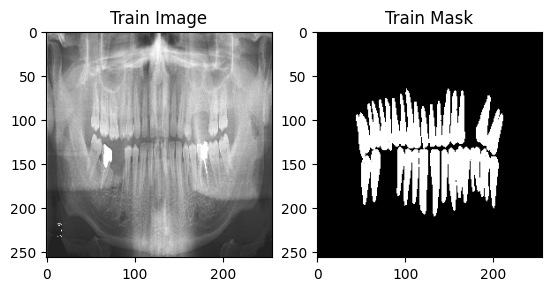

image shape:(1, 256, 256, 3), mask shape:(1, 256, 256, 3)


In [7]:
import random
import matplotlib.pyplot as plt

# Set the random index
index = random.randint(0, len(train_image_generator) - 1)

# Retrieve the image and mask using the random index
image = train_image_generator._get_batches_of_transformed_samples([index])
mask = train_mask_generator._get_batches_of_transformed_samples([index])

# Display the image and mask
plt.subplot(1, 2, 1)
plt.imshow(image[0])
plt.title('Train Image')

plt.subplot(1, 2, 2)
plt.imshow(mask[0])
plt.title('Train Mask')

plt.show()
print(f'image shape:{image.shape}, mask shape:{mask.shape}')

## U-Net Model

### define the model

In [8]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, concatenate

# Define the U-Net model
def unet(input_size):
    # Input layer
    inputs = Input(shape=input_size)

    # Encoder
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(inputs)
    conv1 = Conv2D(64, 3, activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(128, 3, activation='relu', padding='same')(pool1)
    conv2 = Conv2D(128, 3, activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(256, 3, activation='relu', padding='same')(pool2)
    conv3 = Conv2D(256, 3, activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(512, 3, activation='relu', padding='same')(pool3)
    conv4 = Conv2D(512, 3, activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(pool4)
    conv5 = Conv2D(1024, 3, activation='relu', padding='same')(conv5)

    # Decoder
    up6 = UpSampling2D(size=(2, 2))(conv5)
    up6 = Conv2D(512, 2, activation='relu', padding='same')(up6)
    merge6 = concatenate([conv4, up6], axis=3)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(merge6)
    conv6 = Conv2D(512, 3, activation='relu', padding='same')(conv6)

    up7 = UpSampling2D(size=(2, 2))(conv6)
    up7 = Conv2D(256, 2, activation='relu', padding='same')(up7)
    merge7 = concatenate([conv3, up7], axis=3)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(merge7)
    conv7 = Conv2D(256, 3, activation='relu', padding='same')(conv7)

    up8 = UpSampling2D(size=(2, 2))(conv7)
    up8 = Conv2D(128, 2, activation='relu', padding='same')(up8)
    merge8 = concatenate([conv2, up8], axis=3)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(merge8)
    conv8 = Conv2D(128, 3, activation='relu', padding='same')(conv8)

    up9 = UpSampling2D(size=(2, 2))(conv8)
    up9 = Conv2D(64, 2, activation='relu', padding='same')(up9)
    merge9 = concatenate([conv1, up9], axis=3)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(merge9)
    conv9 = Conv2D(64, 3, activation='relu', padding='same')(conv9)

    # Output layer
    conv10 = Conv2D(1, 1, activation='sigmoid')(conv9)

    # Create the model
    model = Model(inputs=inputs, outputs=conv10)

    return model

# Create the U-Net model
model = unet((256, 256, 3))

In [9]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 256, 256, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 256, 256, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 256, 256, 64  36928       ['conv2d[0][0]']                 
                                )                                                             

### Compile the model

In [10]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics = ['accuracy'])

### define a custom callback

In [11]:
from tensorflow import keras
class Callback(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if logs.get('accuracy') >= 0.99 and logs.get('val_accuracy') >= 0.95:
            print("Reached desired accuracy. Stopping training...")
            self.model.stop_training = True

### Train the model

In [ ]:
history = model.fit(train_generator, steps_per_epoch=14, epochs=150, validation_data=val_generator, validation_steps=14, verbose=1, callbacks=[Callback()])

### Save the training model

In [ ]:
model.save('/content/drive/MyDrive/dental-segmentation/save/unet_model.h5')

### Load the trained model weights

In [12]:
model.load_weights('/content/drive/MyDrive/dental-segmentation/save/unet_model.h5')

### predict on validation test

In [129]:
import numpy as np
import matplotlib.pyplot as plt

# Get a batch of validation images and masks
val_images, val_masks = next(val_generator)

# Make predictions
predictions = model.predict(val_images)

# Threshold the predictions
threshold = 0.5
predictions[predictions >= threshold] = 1
predictions[predictions < threshold] = 0

# Convert the predictions to masks
predicted_masks = predictions * 255
predicted_masks = predicted_masks.astype(np.uint8)

1/1 [==============================] - 20s 20s/step


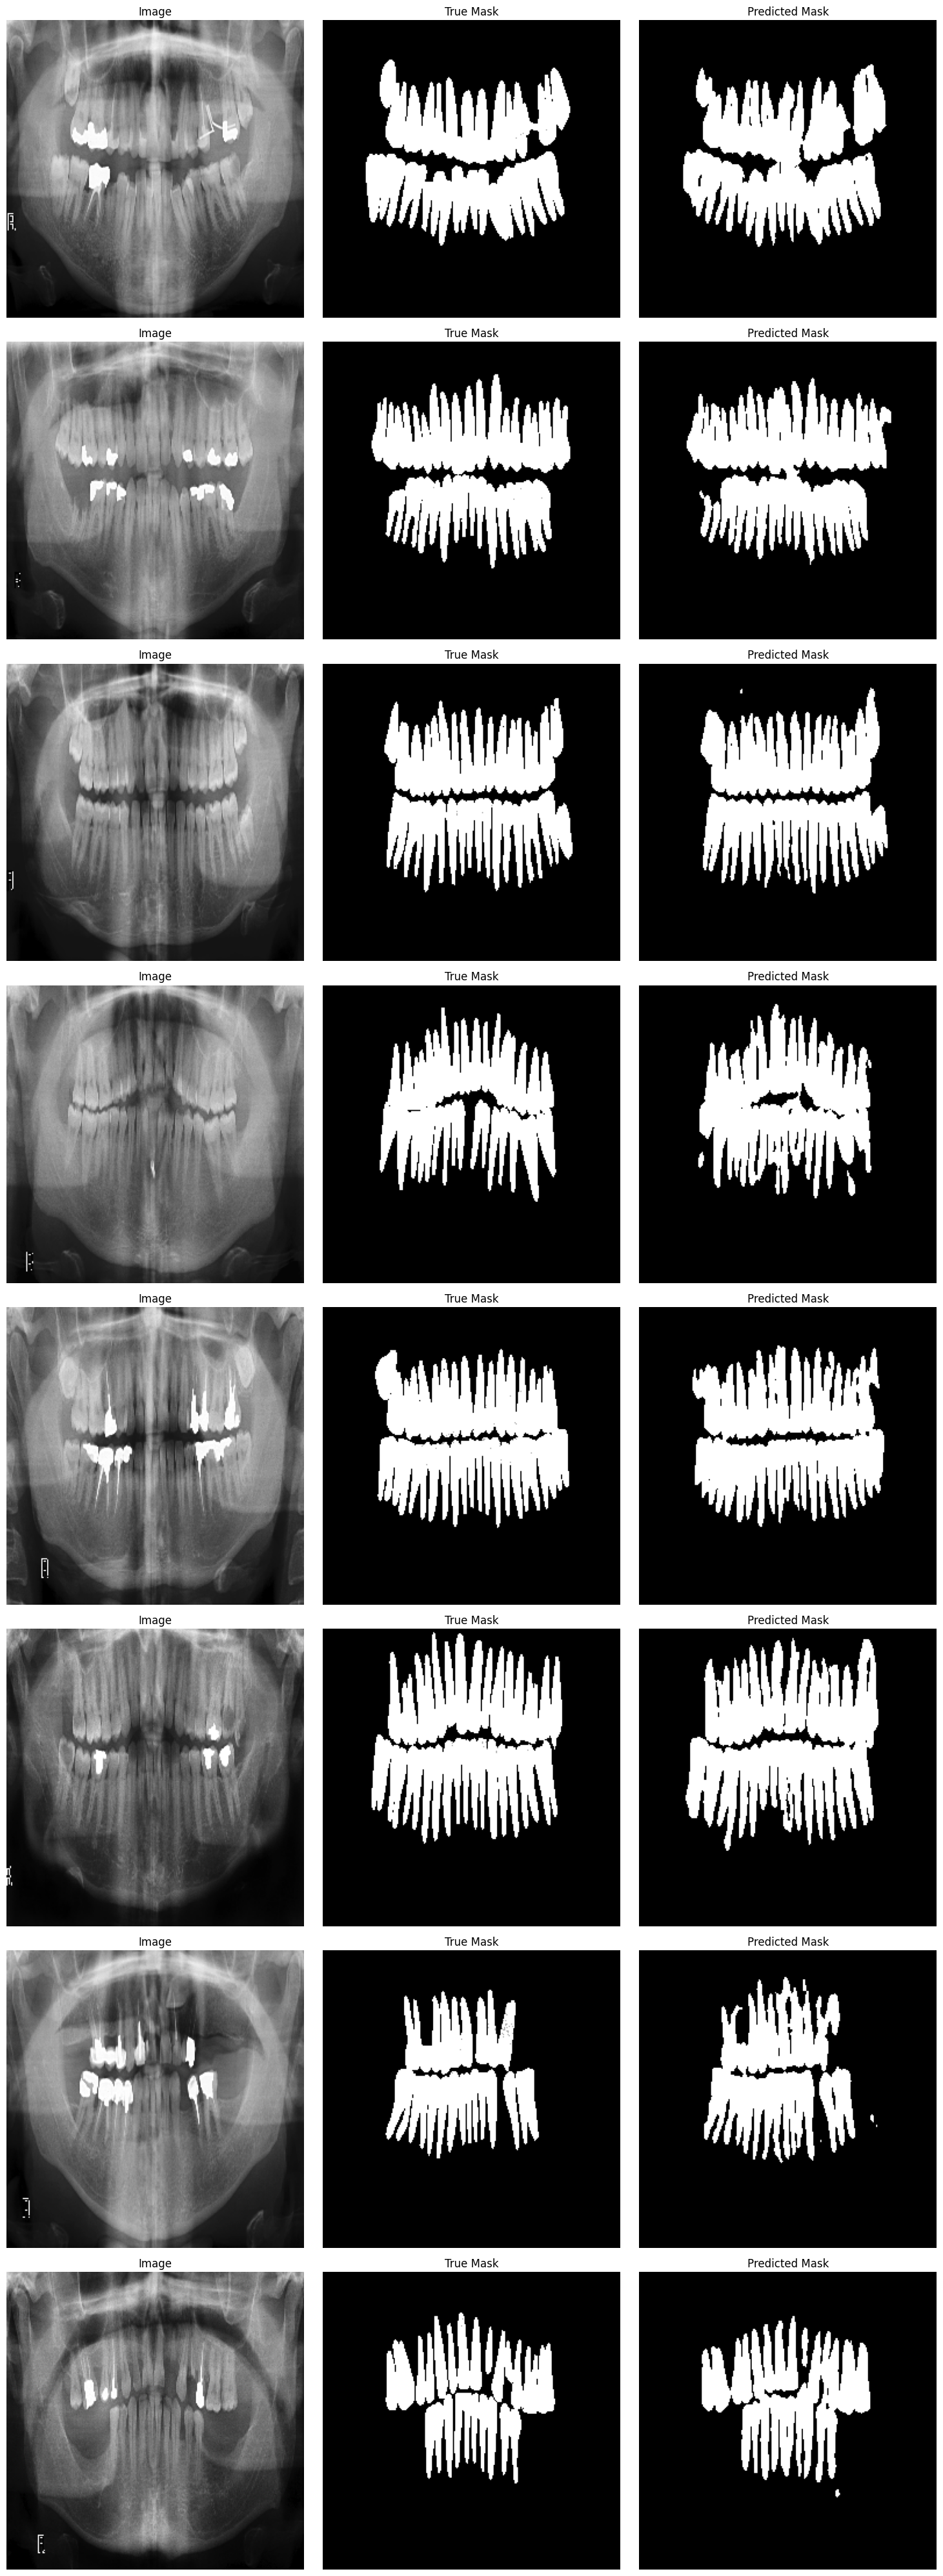

In [130]:
display_images_with_masks(val_images, val_masks, predicted_masks)

Accuracy for image 1: 0.7374114990234375
Accuracy for image 2: 0.7421875
Accuracy for image 3: 0.73370361328125
Accuracy for image 4: 0.7640228271484375
Accuracy for image 5: 0.72467041015625
Accuracy for image 6: 0.7015533447265625
Accuracy for image 7: 0.8180694580078125
Accuracy for image 8: 0.8265228271484375
Overall accuracy: 0.7560176849365234


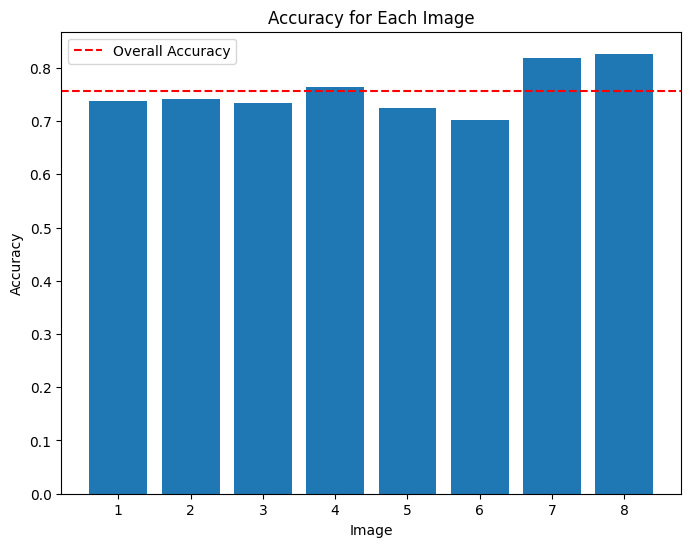

In [131]:
plot_accuracies(val_images, val_masks, predicted_masks)

### Detect tooth decay

In [180]:
255*.9

229.5

In [201]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import random

def detect_decays(images, teeth_masks=None, decay_threshhold=0.9):

    decay_masks = []
    
    for image in images:
      
        # Convert the image to grayscale
        gray_image = cv2.cvtColor(image, cv2.COLOR_RGB2GRAY)
        gray_image = np.expand_dims(gray_image, axis=2)  # Add an additional dimension

        # Apply thresholding to obtain decay mask
        decay_mask = np.zeros(image.shape[:-1] + (1,), dtype=np.uint8)
        decay_mask[gray_image > decay_threshhold] = 1

        # Perform morphological operations on decay mask
        kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (3, 3))
        decay_mask = cv2.morphologyEx(decay_mask, cv2.MORPH_CLOSE, kernel)
        decay_mask = np.expand_dims(decay_mask, axis=2)
        decay_mask = cv2.morphologyEx(decay_mask, cv2.MORPH_OPEN, kernel)
        decay_mask = np.expand_dims(decay_mask, axis=2)
        
        # Append the decay mask to the list
        decay_masks.append(decay_mask)
    
      
    if teeth_masks is not None and teeth_masks.any():
        improved_decay_masks = []
        for decay_mask, teeth_mask in zip(decay_masks, teeth_masks):
            improved_decay_mask = decay_mask * teeth_mask
            improved_decay_masks.append(improved_decay_mask)
        decay_masks = improved_decay_masks

    decay_masks = np.array(decay_masks)
    return decay_masks

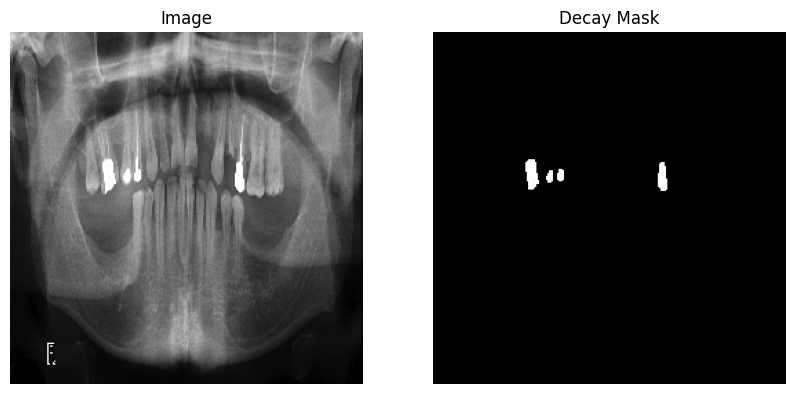

In [207]:
index = random.randint(0, len(val_images)-1)

decay_masks = detect_decays(val_images, predicted_masks)
display_image_with_decay_mask(val_images[index], decay_masks[index])

### Obtain final mask
get the final mask by combining the teeth mask and decay mask. then we would have 3 classes in out segmentation problem:  

- 0: background  
- 1: teeth  
- 2: decay

It is worth noting that images should be of size: (8, 256, 256, 3)  
and teeth masks of size: (8, 256, 256, 1)  
and decay masks of size: (8, 256, 256, 1)  

In [137]:
val_images.shape, predicted_masks.shape, decay_masks.shape

((8, 256, 256, 3), (8, 256, 256, 1), (8, 256, 256, 1))

In [220]:
import numpy as np

def combine_masks(teeth_masks, decay_masks):
    # Check if the shapes of the masks match
    assert teeth_masks.shape == decay_masks.shape

    # Initialize the final array
    combined_masks = np.zeros_like(teeth_masks)

    # Print the unique values in teeth_masks and decay_masks
    #print("Unique values in teeth_masks:", np.unique(teeth_masks))
    #print("Unique values in decay_masks:", np.unique(decay_masks))

    # Set values for background, teeth, and decay
    combined_masks[teeth_masks == 255] = 1
    combined_masks[decay_masks == 255] = 2

    return combined_masks


In [139]:
combined_masks = combine_masks(predicted_masks, decay_masks)

Unique values in teeth_masks: [  0 255]
Unique values in decay_masks: [  0 255]


In [140]:
import matplotlib.colors as colors

def create_colored_mask(final_masks, bg_color='black', teeth_color='white', decay_color='lightcoral'):
    colored_masks = []
    for mask in final_masks:
      colored_mask = np.zeros((mask.shape[0], mask.shape[1], 3))
      for i in range(mask.shape[0]):
          for j in range(mask.shape[1]):
              if(mask[i][j][0] == 0):
                  colored_mask[i][j] = colors.to_rgb(bg_color)
              elif(mask[i][j][0] == 1):
                  colored_mask[i][j] = colors.to_rgb(teeth_color)
              elif(mask[i][j][0] == 2):
                  colored_mask[i][j] = colors.to_rgb(decay_color)
            
      colored_masks.append(colored_mask)
    colored_masks = np.array(colored_masks)
    return colored_masks

In [141]:
colored_masks = create_colored_mask(combined_masks, bg_color="white", teeth_color="blue", decay_color="red")

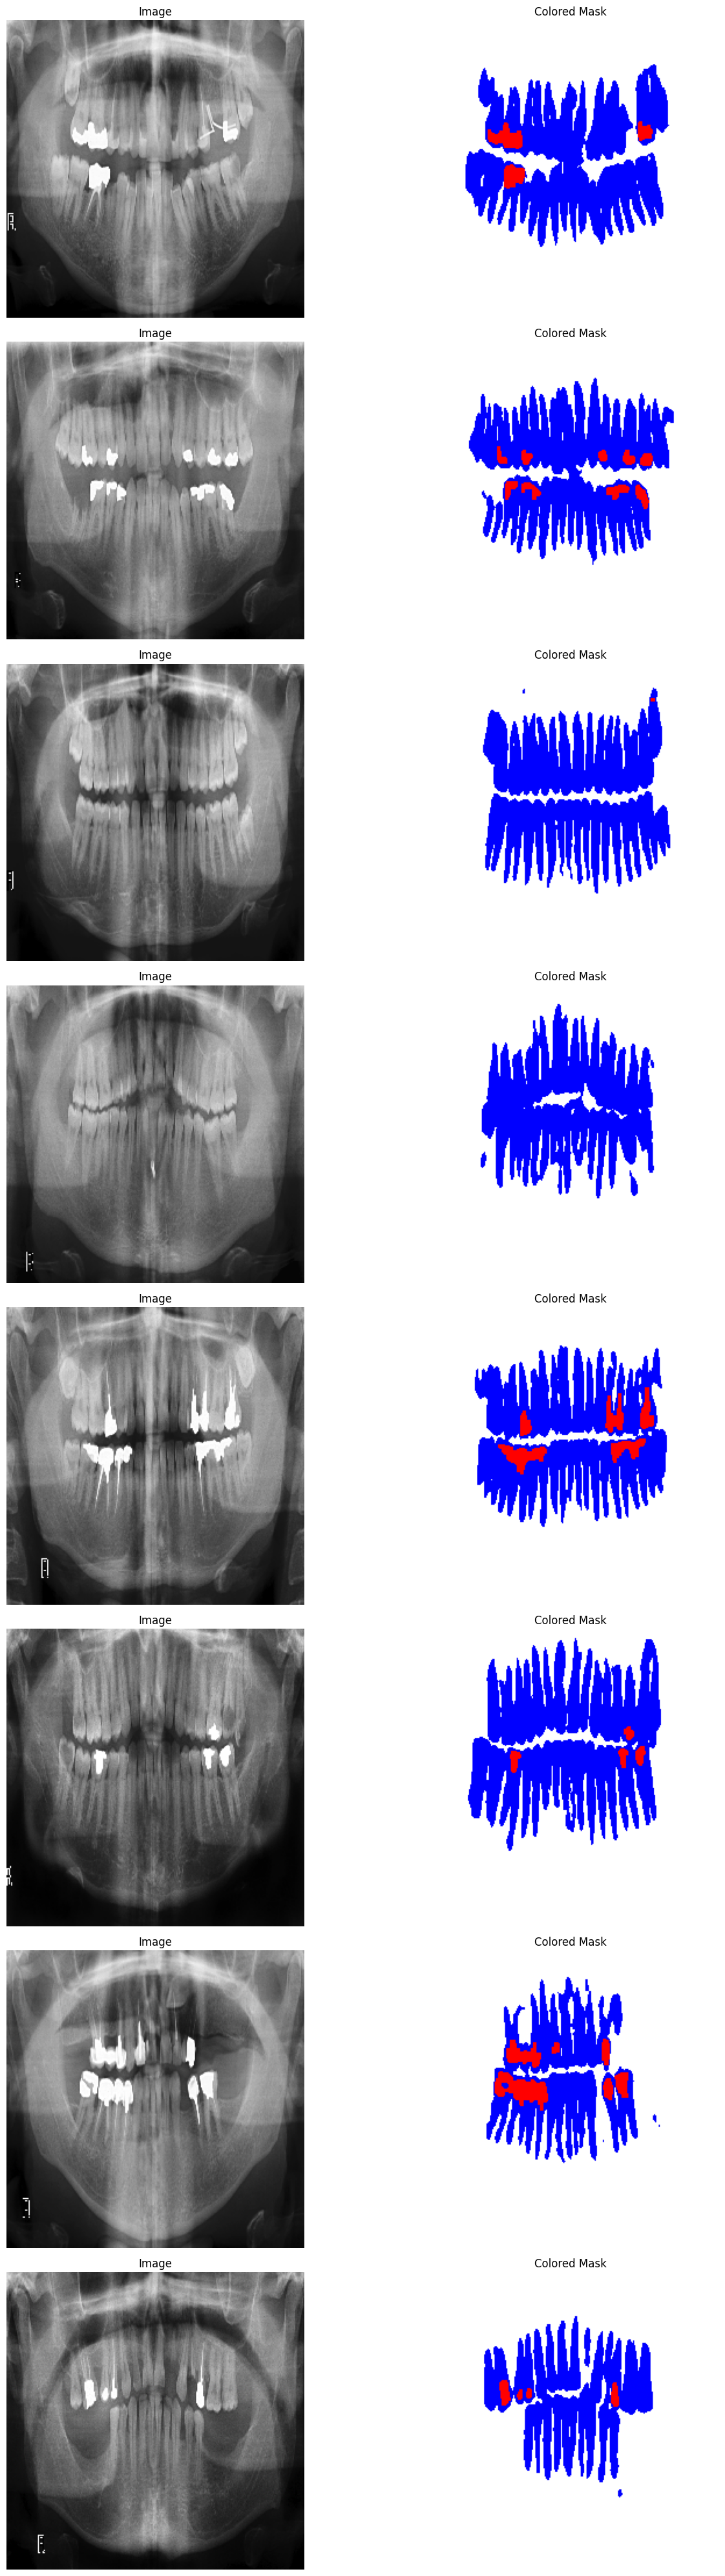

In [142]:
def display_images_with_colored_masks(images, colored_masks, titles=None):
    num_images = len(images)

    # Calculate the number of rows and columns in the plot
    num_rows = num_images
    num_cols = 2

    # Create the plot with subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5*num_images))

    # Iterate over each image and its corresponding masks
    for i in range(num_images):
        image = images[i]
        colored_mask = colored_masks[i]

        # Get the corresponding axes for the current row
        if num_rows > 1:
            ax1, ax2 = axes[i]
        else:
            ax1, ax2 = axes

        # Display the image
        ax1.imshow(image)
        ax1.set_title('Image')

        # Display the colored mask
        ax2.imshow(colored_mask, cmap='gray')
        ax2.set_title('Colored Mask')

        # Turn off the axis labels
        ax1.axis('off')
        ax2.axis('off')

        # Set the title for the current row if provided
        if titles is not None:
            ax1.set_title(titles[i])

    # Adjust the spacing between subplots
    plt.tight_layout()

    # Show the plot
    plt.show()
display_images_with_colored_masks(val_images, colored_masks)

### Segment 4 images in the assignment

In [218]:
import os
import cv2
import numpy as np

test_dir = '/content/drive/MyDrive/dental-segmentation/Data/test'

# List of image paths
image_paths = ["(12).bmp", "(20).bmp", "(30).bmp", "(35).bmp"]
image_paths = [os.path.join(test_dir, path) for path in image_paths]

# Initialize the list to store the resized images
test_images = []

# Iterate over each image path
for path in image_paths:
    if os.path.exists(path):
        # Read the image as RGB
        image = cv2.imread(path, cv2.IMREAD_COLOR)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        # Resize the image to (256, 256)
        resized_image = cv2.resize(image, (256, 256))

        # Rescale the pixel values to the range of 0-1
        rescaled_image = resized_image / 255.0

        # Convert the image to float32
        float32_image = rescaled_image.astype(np.float32)
        
        # Append the rescaled image to the list
        test_images.append(rescaled_image)

# Convert the list to a numpy array
test_images = np.array(test_images)

test_images.shape

(4, 256, 256, 3)

### Predict on test images

In [219]:
# Make predictions
test_predicted_masks = model.predict(test_images)

# Threshold the predictions
threshold = 0.5
test_predicted_masks[test_predicted_masks >= threshold] = 1
test_predicted_masks[test_predicted_masks < threshold] = 0

# Convert the predictions to masks
test_predicted_masks = test_predicted_masks * 255
test_predicted_masks = test_predicted_masks.astype(np.uint8)
test_predicted_masks.shape

1/1 [==============================] - 10s 10s/step


(4, 256, 256, 1)

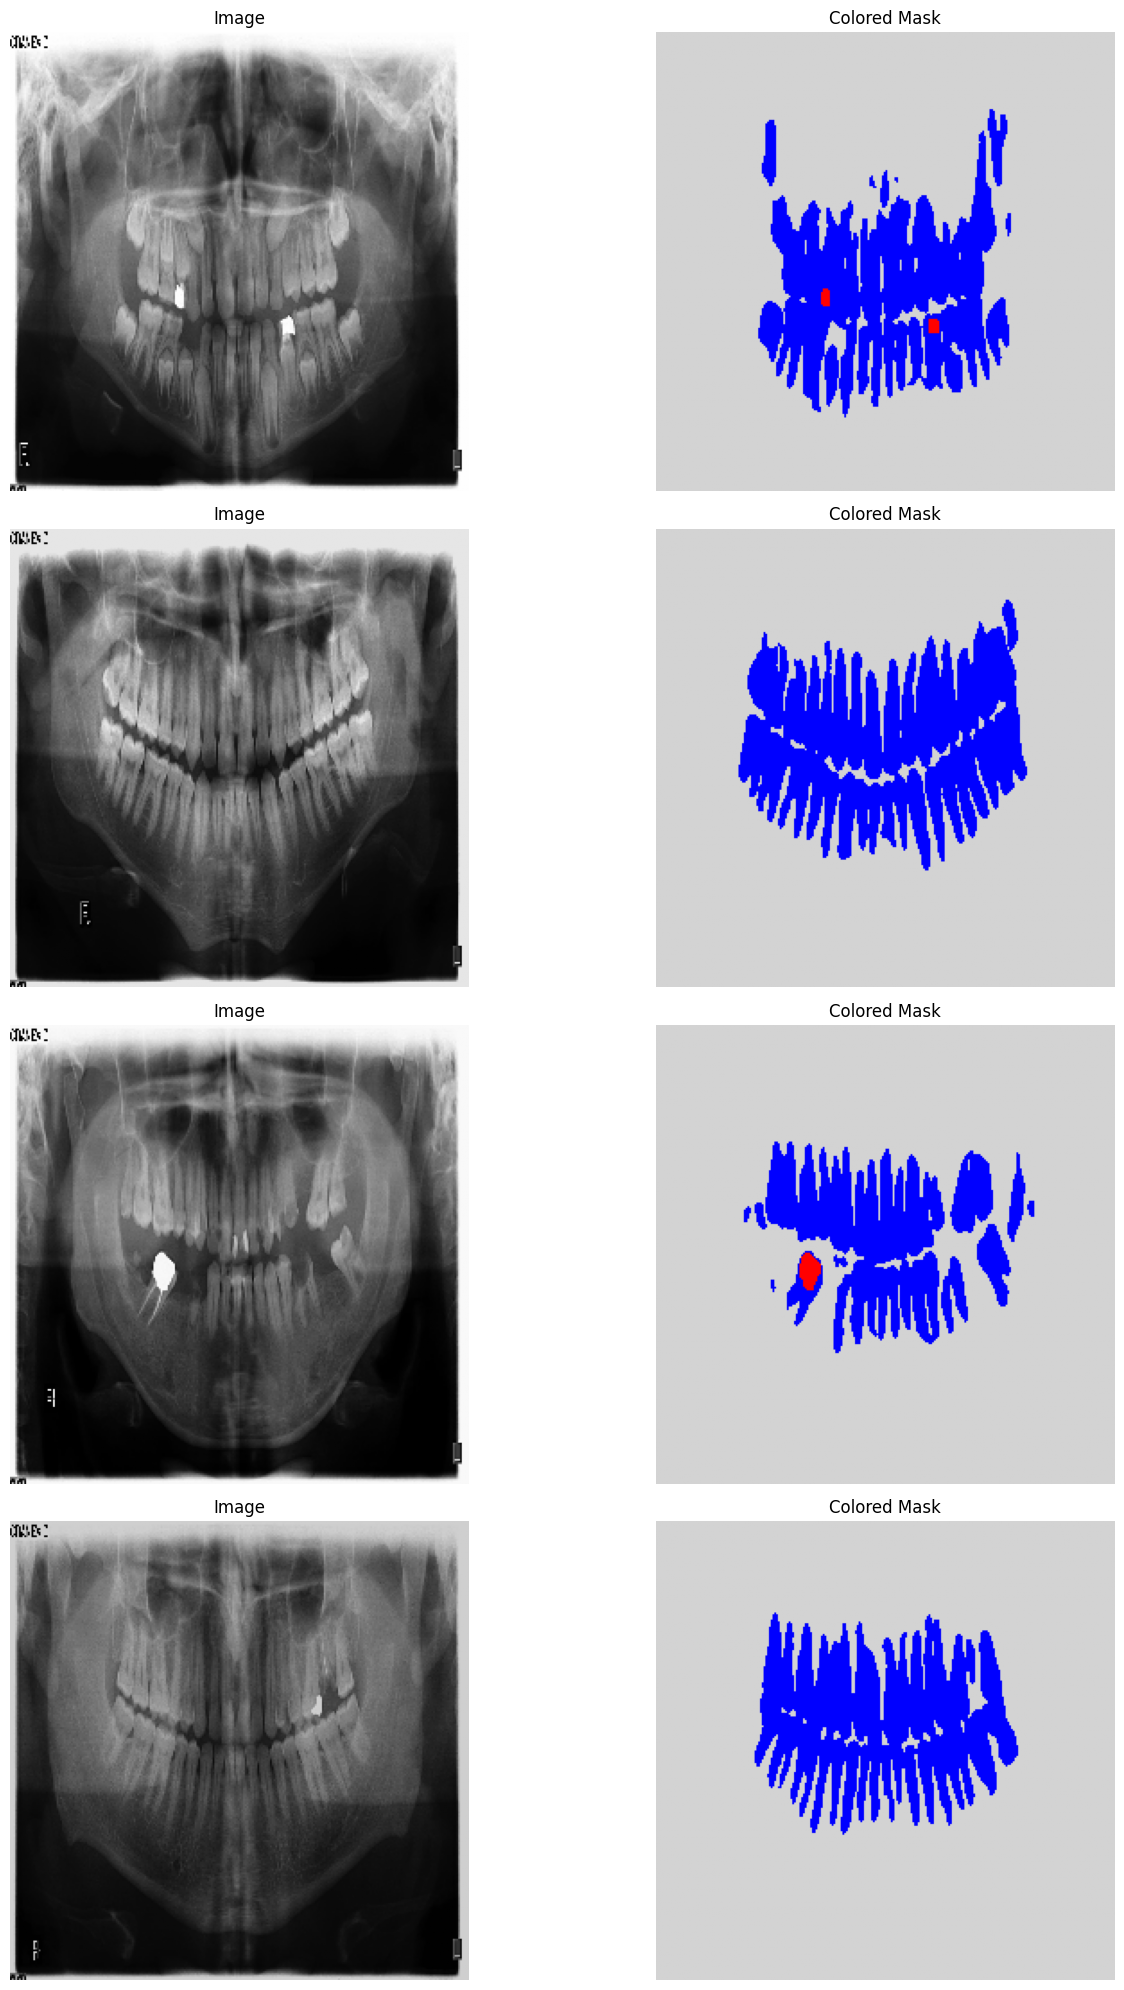

In [225]:
decay_masks = detect_decays(test_images.astype(np.float32), test_predicted_masks)
combined_masks = combine_masks(test_predicted_masks, decay_masks)
colored_masks = create_colored_mask(combined_masks, bg_color="lightgray", teeth_color="blue", decay_color="red")
display_images_with_colored_masks(test_images, colored_masks)

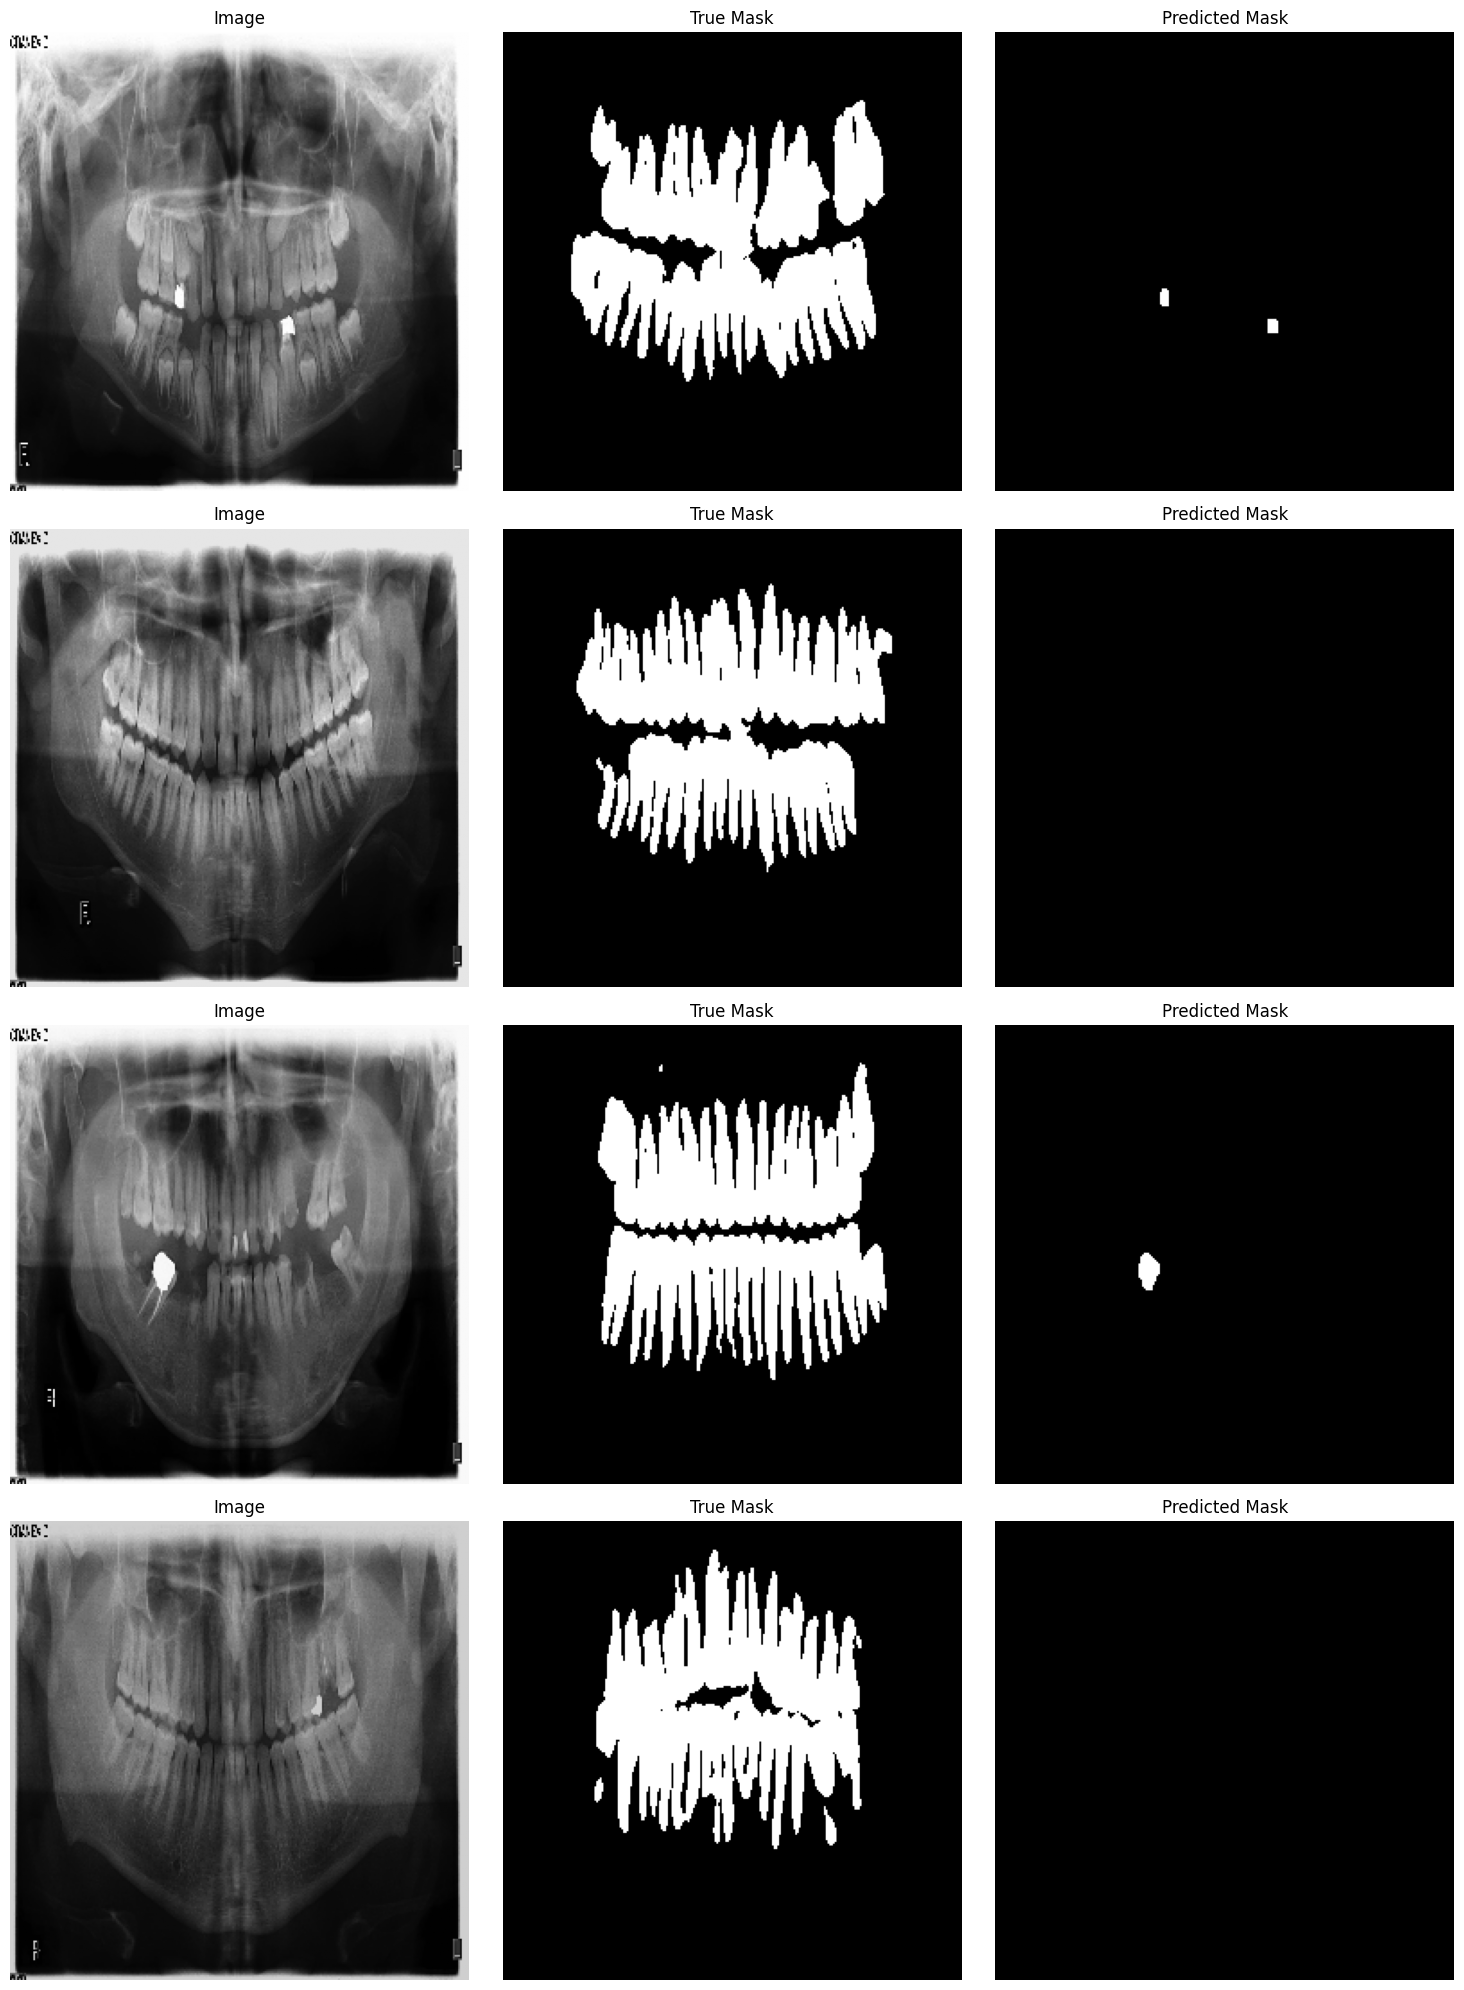

In [222]:
display_images_with_masks(test_images, predicted_masks, decay_masks)

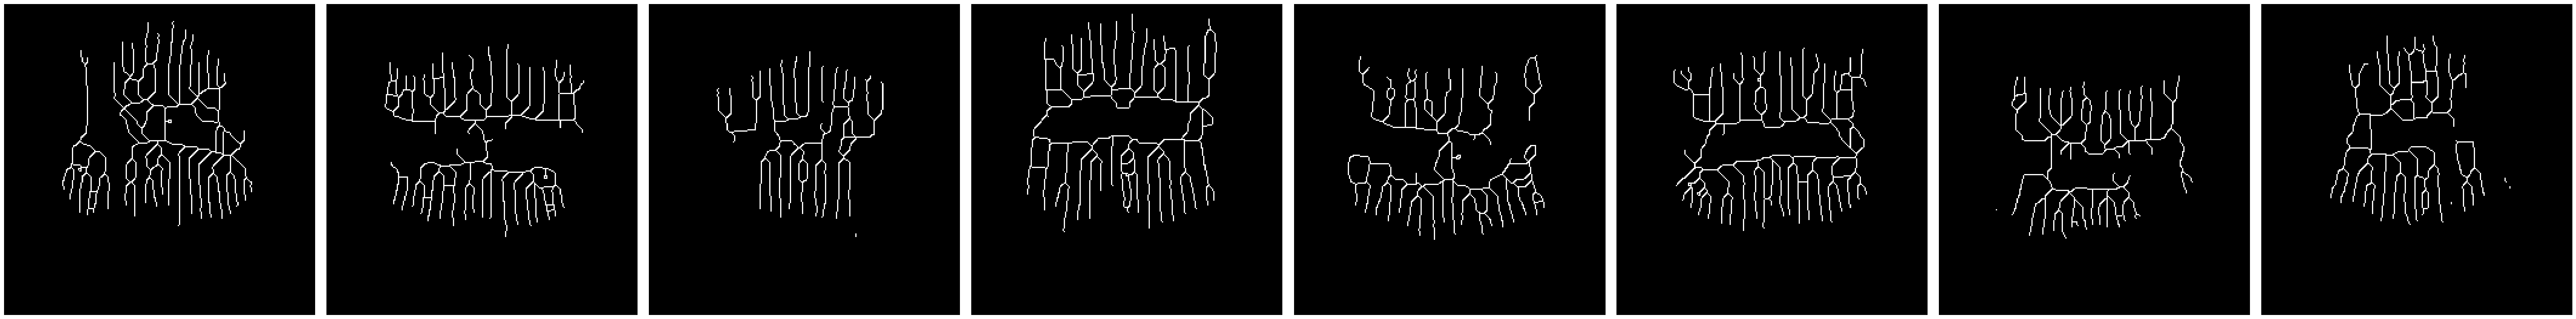

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have a list of segmented teeth masks called 'segmented_teeth_masks'

# Create an empty list to store the skeleton images of each tooth
skeleton_teeth = []

# Iterate over each segmented tooth mask
for tooth_mask in predicted_masks:

    # Threshold the grayscale image to obtain a binary image
    _, binary_mask = cv2.threshold(tooth_mask, 1, 255, cv2.THRESH_BINARY)

    # Perform skeletonization using the thinning algorithm
    skeleton = cv2.ximgproc.thinning(binary_mask)

    # Append the skeleton image to the list
    skeleton_teeth.append(skeleton)

# Display the skeleton images of each tooth
num_teeth = len(skeleton_teeth)
fig, axes = plt.subplots(1, num_teeth, figsize=(num_teeth * 8, 8))

for i, skeleton in enumerate(skeleton_teeth):
    axes[i].imshow(skeleton, cmap='gray')
    axes[i].axis('off')

plt.tight_layout()
plt.show()